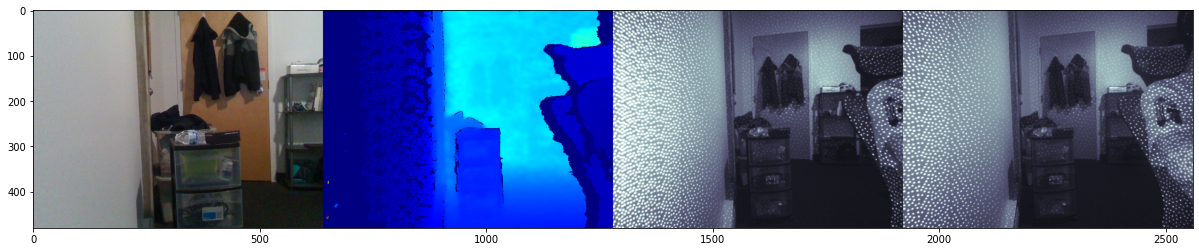

In [15]:
## License: Apache 2.0. See LICENSE file in root directory.
## Copyright(c) 2015-2017 Intel Corporation. All Rights Reserved.

###############################################
##      Open CV and Numpy integration        ##
###############################################

import pyrealsense2 as rs
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Configure depth and color streams
pipeline = rs.pipeline()
config = rs.config()

config.enable_stream(rs.stream.depth, 640, 480, rs.format.z16, 30)
config.enable_stream(rs.stream.infrared, 1, 640, 480, rs.format.y8, 30)
config.enable_stream(rs.stream.infrared, 2, 640, 480, rs.format.y8, 30)
config.enable_stream(rs.stream.color, 640, 480, rs.format.bgr8, 30)

# Start streaming
pipeline.start(config)

try:
    # wait for auto exposure
    for i in range(100):

        # Wait for a coherent pair of frames: depth and color
        frames = pipeline.wait_for_frames()
        depth_frame = frames.get_depth_frame()
        color_frame = frames.get_color_frame()
        ir_frame1 = frames.get_infrared_frame(1)
        ir_frame2 = frames.get_infrared_frame(2)
        if not depth_frame or not color_frame or not ir_frame1 or not ir_frame2:
            continue

        # Convert images to numpy arrays
        depth_image = np.asanyarray(depth_frame.get_data())
        color_image = np.asanyarray(color_frame.get_data())
        ir_image1 = np.asanyarray(ir_frame1.get_data())
        ir_image2 = np.asanyarray(ir_frame2.get_data())

        # Apply colormap on depth image (image must be converted to 8-bit per pixel first)
        depth_colormap = cv2.applyColorMap(cv2.convertScaleAbs(depth_image, alpha=0.03), cv2.COLORMAP_JET)
        ir_colormap1 = cv2.applyColorMap(cv2.convertScaleAbs(ir_image1), cv2.COLORMAP_BONE)
        ir_colormap2 = cv2.applyColorMap(cv2.convertScaleAbs(ir_image2), cv2.COLORMAP_BONE)

        depth_colormap_dim = depth_colormap.shape
        color_colormap_dim = color_image.shape
        ir_colormap_dim = ir_colormap1.shape

        # If depth and color resolutions are different, resize color image to match depth image for display
        if depth_colormap_dim != color_colormap_dim:
            resized_color_image = cv2.resize(color_image, dsize=(depth_colormap_dim[1], depth_colormap_dim[0]), interpolation=cv2.INTER_AREA)
        else:
            resized_color_image = color_image

        if depth_colormap_dim != ir_colormap_dim:
            resized_ir_image1 = cv2.resize(ir_colormap1, dsize=(depth_colormap_dim[1], depth_colormap_dim[0]), interpolation=cv2.INTER_AREA)
            resized_ir_image2 = cv2.resize(ir_colormap2, dsize=(depth_colormap_dim[1], depth_colormap_dim[0]), interpolation=cv2.INTER_AREA)
        else:
            resized_ir_image1 = ir_colormap1
            resized_ir_image2 = ir_colormap2

        images = np.hstack((resized_color_image, depth_colormap, resized_ir_image1,resized_ir_image2))

        # Show images
        # cv2.namedWindow('RealSense', cv2.WINDOW_AUTOSIZE)
        # cv2.imshow('RealSense', images)
        # cv2.waitKey(1)
        # break
    b,g,r = cv2.split(images)       # get b,g,r
    rgb_img = cv2.merge([r,g,b])    # switch it to rgb
    plt.figure(figsize = (40,4))
    plt.imshow(rgb_img)
    plt.show()


finally:
    # Stop streaming
    pipeline.stop()
    cv2.destroyAllWindows()